In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math, random
from collections import deque
from scipy.stats import norm
from scipy.stats import binom, poisson, expon, geom
from statsmodels.stats.weightstats import ztest
from scipy.stats import norm, ttest_ind, ttest_rel, ttest_1samp
from scipy.stats import chi2, chi2_contingency, chisquare
from scipy.stats import f_oneway as anova_1way

from scipy.stats import kruskal # numeric Vs catogerical
from scipy.stats import pearsonr, spearmanr # numeric Vs numeric
from scipy.stats import kstest # cdf
from scipy.stats import levene
from scipy.stats import norm

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.gofplots import qqplot, qqplot_2samples
from scipy.stats import skew, shapiro #[Test for normality]

# Business Case: Apollo Hospitals - Hypothesis Testing

# INDEX
- (A) Problem Statements
- (B) shape, duplicates and null values
- (C) Column Profiling
- (D) Univariate Analysis (distribution plots of all the continuous variable(s) barplots/countplots of all the categorical variables)
- (E) Bivariate Analysis (Relationships between important variables such as hospitalization charges with region, smoker, viral load etc)
- (F) Checking outliers
- (G) Hypothesis Testings
- (H) Observations and Summary of all hypothesis testings result
- (I) Recommendations

# (A) Problem Statements:-

The company wants to know:

* Which variables are significant in predicting the reason for hospitalization for different regions

* How well some variables like viral load, smoking, Severity Level describe the hospitalization charges
* Which variables are significant in predicting viral load

# (B) shape, duplicates and null values

In [3]:
Data = pd.read_csv("D:\Python programmes\Data Collection\scaler_apollo_hospitals.csv")

In [4]:
df = Data.copy(deep = True)

In [5]:
df.shape

(1338, 8)

In [6]:
df.columns

Index(['Unnamed: 0', 'age', 'sex', 'smoker', 'region', 'viral load',
       'severity level', 'hospitalization charges'],
      dtype='object')

In [7]:
df.head()

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


In [8]:
df.tail(2)

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
1336,1336,21,female,no,southwest,8.60,0,5020
1337,1337,61,female,yes,northwest,9.69,0,72853


In [9]:
df.drop(columns= ["Unnamed: 0"], inplace=True)

In [10]:
df.head(3)

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1338 non-null   int64  
 1   sex                      1338 non-null   object 
 2   smoker                   1338 non-null   object 
 3   region                   1338 non-null   object 
 4   viral load               1338 non-null   float64
 5   severity level           1338 non-null   int64  
 6   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 73.3+ KB


### checking and removing duplicates

In [12]:
df.duplicated().sum()

1

In [13]:
df[df.duplicated(keep=False)]

,age,sex,smoker,region,viral load,severity level,hospitalization charges
195,19,male,no,northwest,10.2,0,4099
581,19,male,no,northwest,10.2,0,4099


In [14]:
df.drop_duplicates(keep="first",inplace=True)

In [15]:
df.duplicated().sum()

0

In [16]:
df.reset_index(inplace=True)

In [17]:
df.head(2)

,index,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314


In [18]:
df.drop(columns=["index"],inplace=True)

In [19]:
df.head(1)

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.3,0,42212


### percentage data missing in each columns

In [20]:
#percentage data missing in each columns
for col in df.columns:
    p = df[col].isnull().sum()/len(df[col])*100
    print(col, ": ",round(p,3),"%")

age :  0.0 %
sex :  0.0 %
smoker :  0.0 %
region :  0.0 %
viral load :  0.0 %
severity level :  0.0 %
hospitalization charges :  0.0 %


# (C) Column Profiling

<strong>Column Profiling</strong>

- Age: This is an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government).
- Sex: This is the policy holder's gender, either male or female
- Viral Load: Viral load refers to the amount of virus in an infected person's blood
- Severity Level: This is an integer indicating how severe the patient is
- Smoker: This is yes or no depending on whether the insured regularly smokes tobacco.
- Region: This is the beneficiary's place of residence in Delhi, divided into four geographic regions - northeast, southeast, southwest, or northwest
- Hospitalization charges: Individual medical costs billed to health insurance

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.00,27.00,39.00,51.00,64.00
viral load,1337.0,10.221249,2.033556,5.32,8.76,10.13,11.57,17.71
severity level,1337.0,1.095737,1.205571,0.00,0.00,1.00,2.00,5.00
hospitalization charges,1337.0,33197.806283,30275.900411,2805.00,11866.00,23465.00,41644.00,159426.00


In [22]:
df.describe(include="object").T

,count,unique,top,freq
sex,1337,2,male,675
smoker,1337,2,no,1063
region,1337,4,southeast,364


In [23]:
for col in df.columns:
    print(col,": ",df[col].nunique())

age :  47
sex :  2
smoker :  2
region :  4
viral load :  462
severity level :  6
hospitalization charges :  1320


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1337 non-null   int64  
 1   sex                      1337 non-null   object 
 2   smoker                   1337 non-null   object 
 3   region                   1337 non-null   object 
 4   viral load               1337 non-null   float64
 5   severity level           1337 non-null   int64  
 6   hospitalization charges  1337 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 73.2+ KB


In [25]:
df["severity level"]=df["severity level"].astype("str")

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1337 non-null   int64  
 1   sex                      1337 non-null   object 
 2   smoker                   1337 non-null   object 
 3   region                   1337 non-null   object 
 4   viral load               1337 non-null   float64
 5   severity level           1337 non-null   object 
 6   hospitalization charges  1337 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 73.2+ KB


# (D) Univariate Analysis (distribution plots of all the continuous variable(s) barplots/countplots of all the categorical variables)

### barplots/countplots of all the categorical variables

<AxesSubplot:xlabel='age', ylabel='Count'>

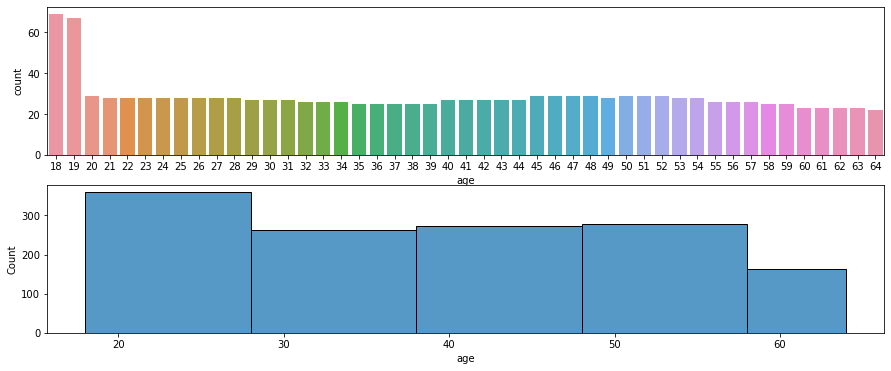

In [27]:
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
sns.countplot(data=df, x="age")
plt.subplot(2,1,2)
sns.histplot(data=df, x="age", bins=[18,28,38,48,58,64])

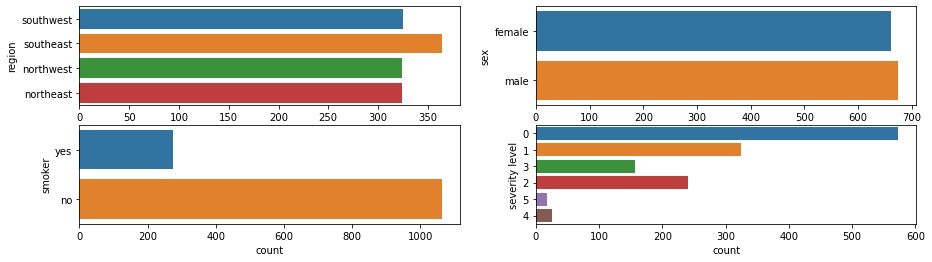

In [28]:
plt.figure(figsize=(15,4))
plt.subplot(2,2,1)
sns.countplot(data=df, y="region")
plt.subplot(2,2,2)
sns.countplot(data=df, y="sex")
plt.subplot(2,2,3)
sns.countplot(data=df, y="smoker")
plt.subplot(2,2,4)
sns.countplot(data=df, y="severity level")
plt.show()

- <strong>most of the patients are non-smoker</strong>
- <strong>most of the patients are having severity level 0</strong>

### distribution plots of all the continuous variable(s)

In [29]:
df.loc[:,("hospitalization charges","viral load")].describe().T

,count,mean,std,min,25%,50%,75%,max
hospitalization charges,1337.0,33197.806283,30275.900411,2805.00,11866.00,23465.00,41644.00,159426.00
viral load,1337.0,10.221249,2.033556,5.32,8.76,10.13,11.57,17.71


`hospitalization charges`

<AxesSubplot:xlabel='hospitalization charges', ylabel='Count'>

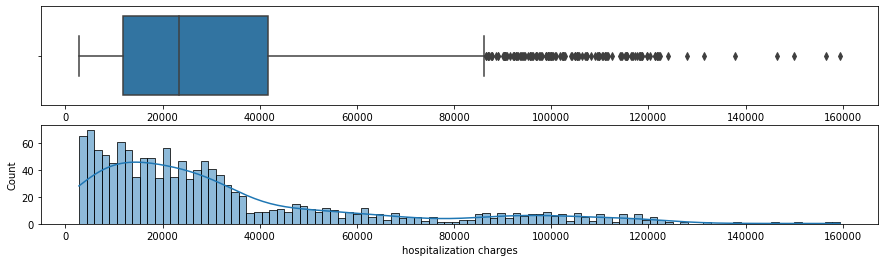

In [30]:
plt.figure(figsize=(15,4))
plt.subplot(2,1,1)
sns.boxplot(data=df, x="hospitalization charges")
plt.subplot(2,1,2)
sns.histplot(data=df, x="hospitalization charges", bins=100, kde=True)

`viral load`

<AxesSubplot:xlabel='viral load', ylabel='Count'>

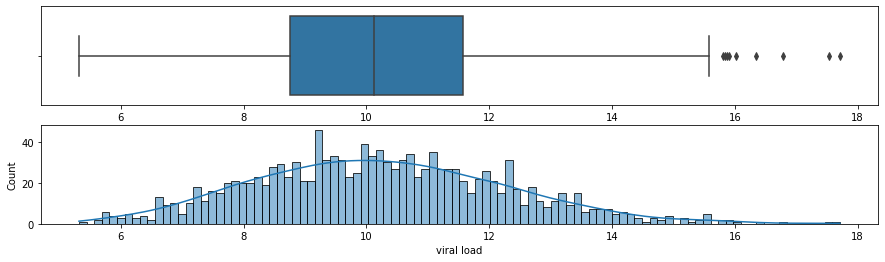

In [31]:
plt.figure(figsize=(15,4))
plt.subplot(2,1,1)
sns.boxplot(data=df, x="viral load")
plt.subplot(2,1,2)
sns.histplot(data=df, x="viral load", bins=100, kde=True)

# (E) Bivariate Analysis (Relationships between important variables such as hospitalization charges with region, smoker, viral load etc)

### hospitalization charges w.r.t different categorical features

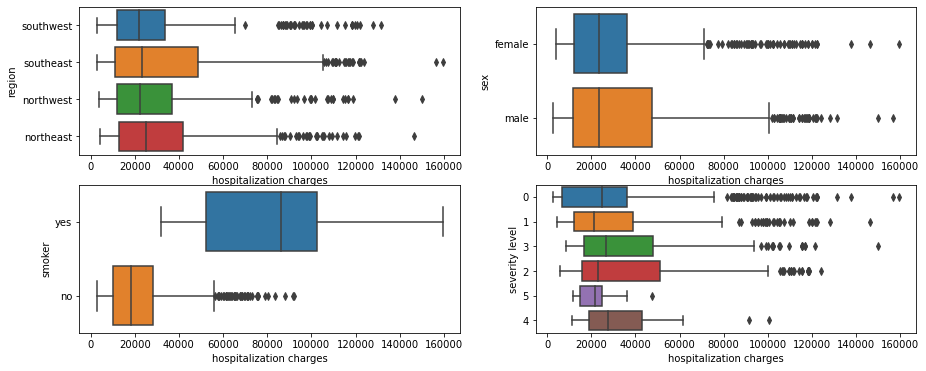

In [32]:
plt.figure(figsize=(15,6))
plt.subplot(2,2,1)
sns.boxplot(data=df, y="region", x="hospitalization charges")
plt.subplot(2,2,2)
sns.boxplot(data=df, y="sex", x="hospitalization charges")
plt.subplot(2,2,3)
sns.boxplot(data=df, y="smoker", x="hospitalization charges")
plt.subplot(2,2,4)
sns.boxplot(data=df, y="severity level", x="hospitalization charges")
plt.show()

<mark>hospitalization charges for smoker patients is quite high compared to non-smoker patients</mark>

### viral load w.r.t different categorical features

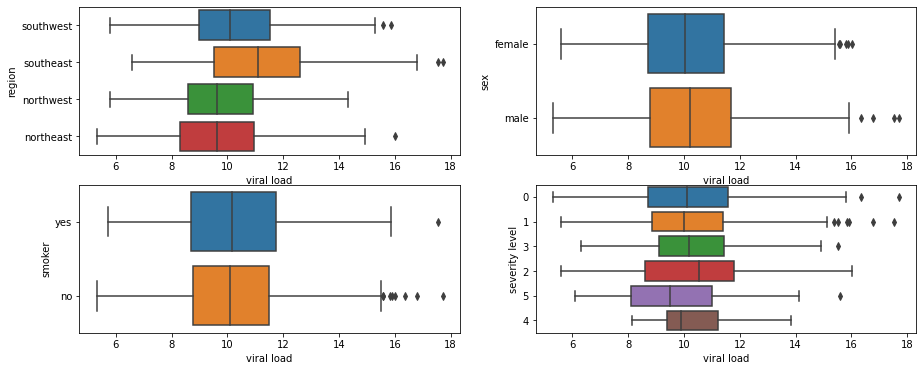

In [33]:
plt.figure(figsize=(15,6))
plt.subplot(2,2,1)
sns.boxplot(data=df, y="region", x="viral load")
plt.subplot(2,2,2)
sns.boxplot(data=df, y="sex", x="viral load")
plt.subplot(2,2,3)
sns.boxplot(data=df, y="smoker", x="viral load")
plt.subplot(2,2,4)
sns.boxplot(data=df, y="severity level", x="viral load")
plt.show()

<mark>viral load in southeast region is high compared to other regions</mark>

### patient age w.r.t different categorical features

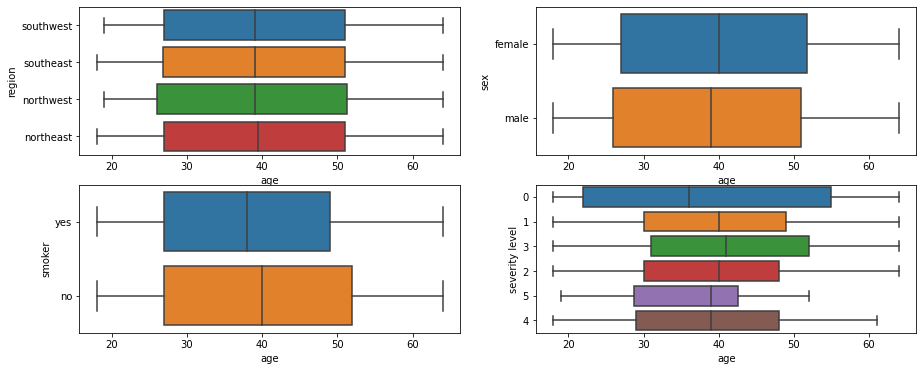

In [34]:
plt.figure(figsize=(15,6))
plt.subplot(2,2,1)
sns.boxplot(data=df, y="region", x="age")
plt.subplot(2,2,2)
sns.boxplot(data=df, y="sex", x="age")
plt.subplot(2,2,3)
sns.boxplot(data=df, y="smoker", x="age")
plt.subplot(2,2,4)
sns.boxplot(data=df, y="severity level", x="age")
plt.show()

### correlation between viral load and hospitalization charges for smokers and non-smokers

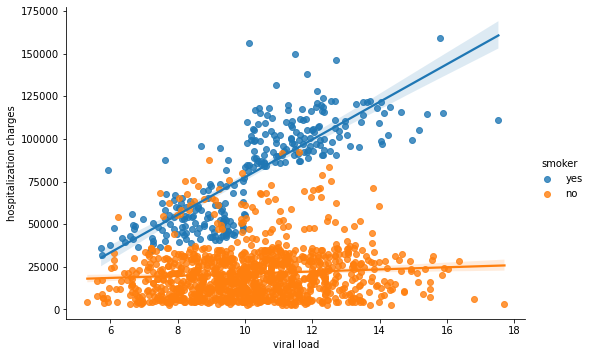

In [35]:
sns.pairplot(data=df,hue="smoker",kind="reg",height=5,aspect=1.5,
             x_vars="viral load",
             y_vars="hospitalization charges"
)

In [36]:
for val in df["smoker"].unique():
    corr_coef = df[df["smoker"]==val].loc[:,("viral load","hospitalization charges")].corr().values[0,1]
    print(val,": corr_coef =",corr_coef)

yes : corr_coef = 0.8065225187583981
no : corr_coef = 0.0841378780026067


- <strong>Smokers:</strong> for smokers hospitalization charges is <strong>highly correlated</strong> with their viral load, which simply means high viral load will result in high hospitalization charges. <strong>correlation coefficient = 0.80</strong>
- <strong>Non-smokers:</strong> for non-smokers hospitalization charges is <strong>very less correlated</strong> with their viral load, which simply means high viral load will not result in high hospitalization charges. <strong>correlation coefficient = 0.08</strong><br>

### correlation between viral load and hospitalization charges for different regions

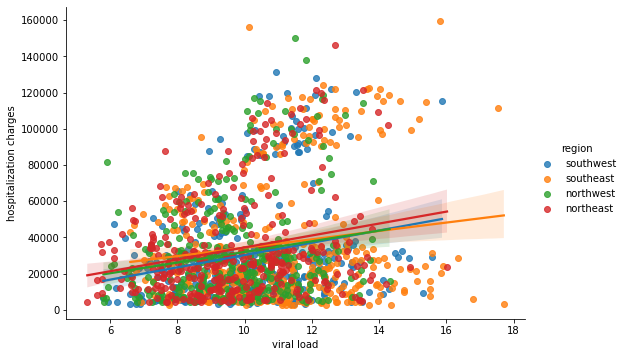

In [37]:
sns.pairplot(data=df, hue="region", kind="reg", height=5, aspect=1.5,
             x_vars="viral load",
             y_vars="hospitalization charges"
)

In [38]:
for val in df["region"].unique():
    corr_coef = df[df["region"]==val].loc[:,("viral load","hospitalization charges")].corr().values[0,1]
    print(val,": corr_coef =",corr_coef)

southwest : corr_coef = 0.2229007798797328
southeast : corr_coef = 0.14311726015932222
northwest : corr_coef = 0.18225902210070546
northeast : corr_coef = 0.23168092793336884


<mark>correlation coef value is low in all regions for viral load w.r.t hospitalization charges</mark>

### correlation between viral load and hospitalization charges for different severity level

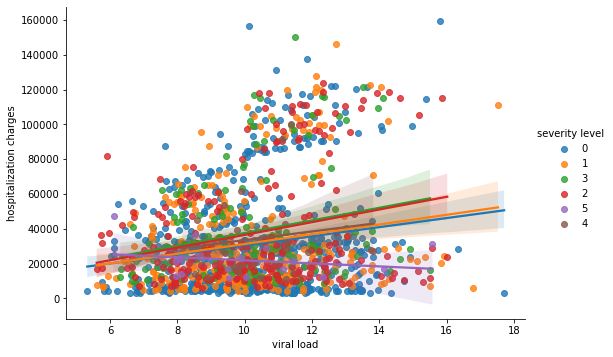

In [39]:
sns.pairplot(data=df, hue="severity level", kind="reg", height=5, aspect=1.5,
             x_vars="viral load",
             y_vars="hospitalization charges"
)

In [40]:
for val in df["severity level"].unique():
    corr_coef = df[df["severity level"]==val].loc[:,("viral load","hospitalization charges")].corr().values[0,1]
    print("severity level ",val,": corr_coef =",corr_coef)

severity level  0 : corr_coef = 0.17504684784467833
severity level  1 : corr_coef = 0.1924513065986874
severity level  3 : corr_coef = 0.22695297640331946
severity level  2 : corr_coef = 0.24554856332796499
severity level  5 : corr_coef = -0.21773265759144012
severity level  4 : corr_coef = 0.16791497178677495


<mark>correlation coef value is low in all severity level for viral load w.r.t hospitalization charges</mark>

# (F) Checking outliers

### <mark>creating a function to remove outliers from a given array (using IQR method)</mark>

In [41]:
def remove_outliers(arr):
    IQR = np.quantile(arr, 0.75)-np.quantile(arr, 0.25)
    LL = np.quantile(arr, 0.25)-1.5*IQR
    UL = np.quantile(arr, 0.75)+1.5*IQR
    arr = arr[arr>LL]
    arr = arr[arr<UL]
    return (arr)

### outliers% in hospitalization charges for smoker vs non-smoker

In [42]:
ans = []
for val in df["smoker"].unique():
    arr = df[df["smoker"]==val]["hospitalization charges"].values
    percnt = (len(arr)-len(remove_outliers(arr)))/len(arr)*100
    ans.append(percnt)
    print(val,":  ",round(percnt,2),"%")

yes :   0.0 %
no :   4.33 %


# (G) Hypothesis Testings

### (G.1) Hypothesis Testing: Prove (or disprove) that the hospitalization of people who do smoking is greater than those who don't?

In [43]:
# group1 = smokers
# group2 = Non-smokers

In [44]:
smoker_yes = df[df["smoker"]=="yes"]["hospitalization charges"].values
smoker_yes = remove_outliers(smoker_yes)        #removing outliers before hypothesis testing

smoker_no = df[df["smoker"]=="no"]["hospitalization charges"].values
smoker_no = remove_outliers(smoker_no)          #removing outliers before hypothesis testing

In [45]:
df.groupby("smoker")["hospitalization charges"].describe()

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1063.0,21101.655691,14982.435547,2805.0,9972.5,18364.0,28407.50,92277.0
yes,274.0,80125.572993,28853.891137,32074.0,52065.5,86141.0,102548.25,159426.0


#### checking normality of two samples

<AxesSubplot:xlabel='hospitalization charges', ylabel='Count'>

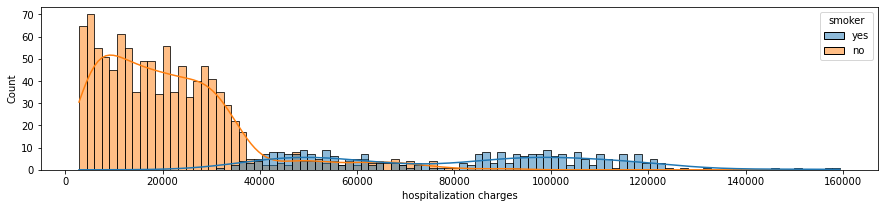

In [46]:
plt.figure(figsize=(15,3))
sns.histplot(data=df, x="hospitalization charges", hue="smoker", bins=100, kde=True)

In [47]:
(skew(smoker_yes),skew(smoker_no))

(0.12751309394152952, 0.6442207914505966)

In [48]:
shapiro(smoker_yes)

ShapiroResult(statistic=0.939551830291748, pvalue=3.6248792856241607e-09)

In [49]:
shapiro(smoker_no)

ShapiroResult(statistic=0.9500976800918579, pvalue=4.5260601694686375e-18)

pvalues of both the groups are smaller than 0.05

<mark>both the samples are not from normal distribution</mark>

#### comparing distribution of two samples

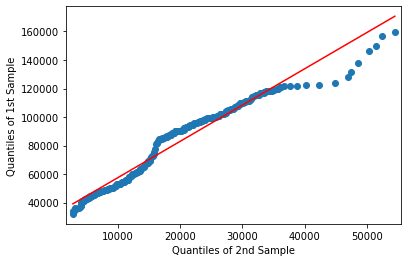

In [50]:
qqplot_2samples(smoker_yes, smoker_no, line="r")
plt.show()

<mark>both groups have different distribution</mark>

#### comparing variance of two samples

In [51]:
# H0: two groups have same variance
# H1: two groups do not have same variance
# alpha = 0.05
levene(smoker_yes, smoker_no) 

LeveneResult(statistic=695.9903331902099, pvalue=5.3260482147739125e-123)

pvalue $=5.32\times 10^{-123}<0.05$<br>
H0 is rejected, two groups have different variance

<strong>`Since, data is skewed and two groups have different variance then we will use Kruskal test`</strong>

In [52]:
# group1 = smokers
# group2 = Non-smokers

In [53]:
# H0: two groups have same median hospitalization charges
# H1: two groups have significantly different median hospitalization charges
# alpha = 0.05
kruskal(smoker_yes, smoker_no)

KruskalResult(statistic=626.4924046385086, pvalue=2.8953064701245963e-138)

pvalue $=2.89\times 10^{-138}<0.05$<br>
H0 is rejected, <mark><strong>two groups have significantly different median hospitalization charges</strong></mark>

<AxesSubplot:xlabel='hospitalization charges', ylabel='smoker'>

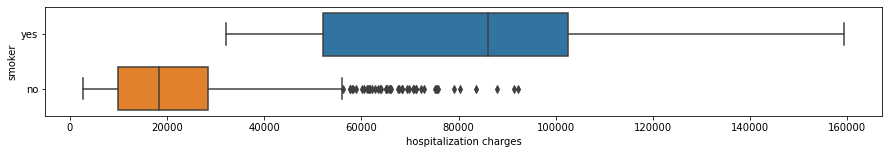

In [54]:
plt.figure(figsize=(15,2))
sns.boxplot(data=df, y="smoker", x="hospitalization charges")

<mark><strong>Hence, hospitalisation charges of smoker group is significantly higher compared to non-smoker group</strong></mark>

### (G.2) Hypothesis Testing: Prove (or disprove) with statistical evidence that the viral load of females is different from that of males

In [55]:
# group1 = viral_load_male
# group2 = viral_load_female

In [56]:
viral_load_male = df[df["sex"]=="male"]["viral load"].values
viral_load_male = remove_outliers(viral_load_male)           #removing outliers before hypothesis testing

viral_load_female = df[df["sex"]=="female"]["viral load"].values
viral_load_female = remove_outliers(viral_load_female)       #removing outliers before hypothesis testing

In [57]:
df.groupby("sex")["viral load"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,662.0,10.126073,2.015402,5.60,8.71,10.035,11.4375,16.02
male,675.0,10.314593,2.048402,5.32,8.80,10.230,11.6750,17.71


#### checking normality of two samples

<AxesSubplot:xlabel='viral load', ylabel='Count'>

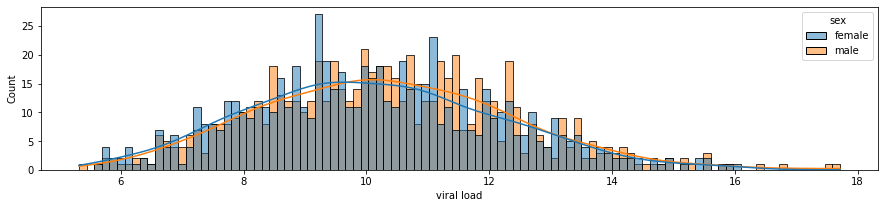

In [58]:
plt.figure(figsize=(15,3))
sns.histplot(data=df, x="viral load", hue="sex", bins=100, kde=True)

In [59]:
(skew(viral_load_male),skew(viral_load_female))

(0.16702990969981357, 0.1519675249118531)

In [60]:
shapiro(viral_load_male)

ShapiroResult(statistic=0.9956651926040649, pvalue=0.05867023766040802)

In [61]:
shapiro(viral_load_female)

ShapiroResult(statistic=0.9939059615135193, pvalue=0.009464985691010952)

<mark><strong>Data is very less skewed and can be assumed that samples are from normal distribution</strong></mark>

#### comparing distribution of two samples

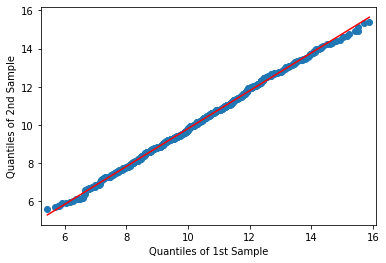

In [62]:
qqplot_2samples(viral_load_male, viral_load_female, line="r")
plt.show()

<mark>both groups have similar distribution</mark>

#### comparing variance of two samples

In [63]:
# H0: two groups have same variance
# H1: two groups do not have same variance
# alpha = 0.05
levene(viral_load_male, viral_load_female)

LeveneResult(statistic=0.011122086498903007, pvalue=0.9160257247777945)

pvalue $=0.91>0.05$<br>
H0 is not rejected, two groups have similar variance

<strong>`Since, data is normal and two groups have similar variance then we will use two sample ttest`</strong>

In [64]:
# H0: two groups have same mean viral load
# H1: two groups have significantly different mean viral load
# alpha = 0.05
ttest_ind(viral_load_male, viral_load_female)

Ttest_indResult(statistic=1.7633901121723212, pvalue=0.07806499971098378)

pvalue $=0.07>0.05$<br>
H0 is not rejected, <mark><strong>two groups have similar mean viral load</strong></mark>

<mark><strong>Hence, mean viral load of females is similar to that of males</strong></mark>

### (G.3) Hypothesis Testing: Is the proportion of smoking significantly different across different regions? (Chi-square)

In [65]:
CT = pd.crosstab(index=df["region"], columns=df["smoker"]); CT

smoker,no,yes
region,,
northeast,257,67
northwest,266,58
southeast,273,91
southwest,267,58


In [66]:
observed = CT
chi_stat, p_value, dfreedom, exp_freq = chi2_contingency(observed)
print(chi_stat, p_value)

7.27790254132191 0.06354826573182334


pvalue $=0.06>0.05$<br>
<mark><strong>Hence, the proportion of smoking is similar across different regions</strong></mark>

### (G.4) Hypothesis Testing: Is the mean viral load of women with 0 Severity level , 1 Severity level, and 2 Severity level the same? Explain your answer with statistical evidence

In [67]:
female_severity_level_0 = df[(df["sex"]=="female")&(df["severity level"]=="0")]["viral load"].values
female_severity_level_0 = remove_outliers(female_severity_level_0)
female_severity_level_0[:10]

array([ 9.3 ,  8.58,  8.61,  8.76, 13.27, 12.  ,  7.7 ,  8.77,  8.87,
       11.59])

In [68]:
female_severity_level_1 = df[(df["sex"]=="female")&(df["severity level"]=="1")]["viral load"].values
female_severity_level_1 = remove_outliers(female_severity_level_1)
female_severity_level_1[:10]

array([11.15, 10.26, 10.8 , 10.64,  7.63,  8.64,  9.86,  8.26, 12.54,
        9.17])

In [69]:
female_severity_level_2 = df[(df["sex"]=="female")&(df["severity level"]=="2")]["viral load"].values
female_severity_level_2 = remove_outliers(female_severity_level_2)
female_severity_level_2[:10]

array([10.92, 12.21, 10.27, 12.89, 11.21, 10.61, 12.44, 13.03, 11.6 ,
       10.43])

In [70]:
df[df["sex"]=="female"].groupby("severity level")["viral load"].describe().loc[("0","1","2"),:]

,count,mean,std,min,25%,50%,75%,max
severity level,,,,,,,,
0,289.0,10.120727,1.989071,5.76,8.7300,9.980,11.530,15.80
1,158.0,10.017468,1.929065,5.60,8.6575,9.855,11.315,15.36
2,119.0,10.216807,2.209687,5.73,8.5900,10.430,11.585,16.02


#### checking normality of samples

<AxesSubplot:xlabel='viral load', ylabel='Count'>

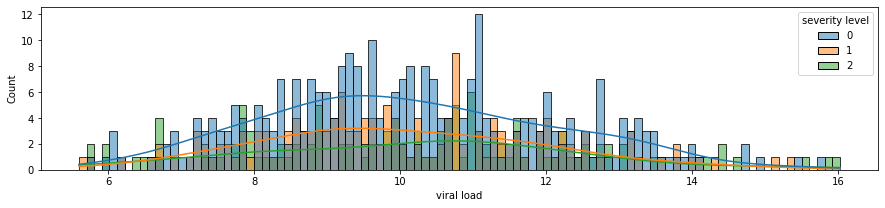

In [71]:
plt.figure(figsize=(15,3))
mask = df["severity level"].isin(["0","1","2"])
sns.histplot(data=df[(df["sex"]=="female")&mask], x="viral load", hue="severity level", bins=100, kde=True)

In [72]:
(skew(female_severity_level_0),skew(female_severity_level_1),skew(female_severity_level_2))

(0.20674370917561313, 0.19951055245030974, 0.16704922718254475)

In [73]:
shapiro(female_severity_level_0)

ShapiroResult(statistic=0.9894893765449524, pvalue=0.03562482073903084)

In [74]:
shapiro(female_severity_level_1)

ShapiroResult(statistic=0.9934722185134888, pvalue=0.7040449380874634)

In [75]:
shapiro(female_severity_level_2)

ShapiroResult(statistic=0.9860242009162903, pvalue=0.2586005926132202)

<mark>since, pvalue > 0.05 then data can be assumed normal</mark>

In [76]:
(np.std(female_severity_level_0),np.std(female_severity_level_1),np.std(female_severity_level_2))

(1.9606178235321066, 1.8810461628361916, 2.2003826759514067)

<mark>variance are similar</mark>

<strong>`Since, data is normal and groups have similar variance then we will use one way anova`</strong>

In [77]:
# we have three groups of viral loads
# female_severity_level_0
# female_severity_level_1
# female_severity_level_2

In [78]:
# H0: groups have same mean viral load
# H1: groups have significantly different mean viral load
# alpha = 0.05

In [79]:
anova_1way(female_severity_level_0,female_severity_level_1,female_severity_level_2)

F_onewayResult(statistic=0.46696750887713423, pvalue=0.6271439098593244)

pvalue $=0.62>0.05$<br>
H0 is not rejected<br>
<mark><strong>Hence, Yes the mean viral load of women with 0 Severity level , 1 Severity level, and 2 Severity level the same</strong></mark>

# (H) Observations and Summary of all hypothesis testings result

<strong>All observations:-</strong>
- <strong>most of the patients are non-smoker</strong>
- <strong>most of the patients are having severity level 0</strong>
- viral load in southeast region is high compared to other regions
- Hospitalization charges for smoker patients is quite high compared to non-smoker patients
- <strong>Smokers:</strong> for smokers hospitalization charges is <strong>highly correlated</strong> with their viral load, which simply means high viral load will result in high hospitalization charges. <strong>correlation coefficient = 0.80</strong>
- <strong>Non-smokers:</strong> for non-smokers hospitalization charges is <strong>very less correlated</strong> with their viral load, which simply means high viral load will not result in high hospitalization charges. <strong>correlation coefficient = 0.08</strong><br>

<strong>Results of all hypothesis testings:-</strong><br>
- Median Hospitalisation charges of smoker group is significantly higher compared to non-smoker group
- Mean viral load of females is similar to that of males
- The proportion of smoking is similar across different regions
- The mean viral load of women with 0 Severity level , 1 Severity level, and 2 Severity level are the same

# (I) Recommendations

- It is observed that smokers with high viral load paid high hospitalization charges, which indicates that smokers have weak immune towards covid. Medical insurance can be promoted to smoker group.
- Viral load in southeast region of Delhi was highest, so medical insurance should be promoted through adverstisement in this region.